# Becle Investment Case
## Advent International

### Santana Luz
#### Agosto-Septiembre 2025

##### Instrucciones generales:
Hacer dos slides donde se presente la descripción general del sector (Insdutry overview) y descripción general de la empresa (Company Overview) que en este caso será: Becle.

# Primera Slide

#### Industry Overview

In [41]:
# Librerías

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display
from tabulate import tabulate

In [16]:
# Preparamos los datos:
FILE_WORLD = "Passport Spirits World.xlsx"   # La base de datos fue proporcionada por los organizadores

def autodetect_header(path, sheet):
    """Lee toda la hoja sin header y detecta la fila que contiene 'Geography' y 'Category'."""
    raw = pd.read_excel(path, sheet_name=sheet, header=None)
    header_row = None
    for i in range(min(30, len(raw))):  # buscamos arriba (primeras ~30 filas)
        row_vals = raw.iloc[i].astype(str).str.strip()
        if ("Geography" in row_vals.values) and ("Category" in row_vals.values):
            header_row = i
            break
    if header_row is None:
        # fallback: si no encontramos Category (algunas hojas de shares), busca Geography + Data Type
        for i in range(min(30, len(raw))):
            row_vals = raw.iloc[i].astype(str).str.strip()
            if ("Geography" in row_vals.values) and ("Data Type" in row_vals.values):
                header_row = i
                break
    if header_row is None:
        raise RuntimeError(f"No pude detectar encabezados en la hoja '{sheet}'. Revisa las primeras filas.")
    # re-lee con esa fila como encabezado
    df = pd.read_excel(path, sheet_name=sheet, header=header_row)
    return df


In [2]:
# Colocamos las definiciones correspondientes:

def clean_cols(df):
    """Normaliza nombres de columnas: minúsculas, quita espacios extra, convierte años a str."""
    def norm(c):
        c = str(c).strip()
        c = re.sub(r"\s+", " ", c)  # colapsa espacios
        return c
    df = df.rename(columns={c: norm(c) for c in df.columns})
    # copia en minúsculas para trabajar, pero preserva originales para años:
    lower_map = {c: c.lower() for c in df.columns}
    df.columns = [lower_map[c] for c in df.columns]
    # renombra años numéricos a string "2019","2024"
    rename_years = {}
    for c in df.columns:
        try:
            y = int(c)
            rename_years[c] = str(y)
        except:
            pass
    if rename_years:
        df = df.rename(columns=rename_years)
    return df

def filter_spirits_value(df):
    """Filtra Category=Spirits y Data Type que contenga 'value' (y, si hay Unit, que tenga US$ o million)."""
    cols = df.columns
    has_category = "category" in cols
    has_dtype    = "data type" in cols
    has_unit     = "unit" in cols

    m = pd.Series(True, index=df.index)
    if has_category:
        m &= df["category"].astype(str).str.strip().str.casefold().eq("spirits")
    if has_dtype:
        m &= df["data type"].astype(str).str.casefold().str.contains("value")
    if has_unit:
        # relajado: si existe, buscamos pista de dólares/millions
        unit_ok = df["unit"].astype(str).str.casefold().str.contains("us", na=False) | \
                  df["unit"].astype(str).str.casefold().str.contains("million", na=False)
        # si ninguna fila cumple unit_ok pero sí tenemos data type=value, no bloqueamos; solo aplicamos si hay coincidencias
        if unit_ok.any():
            m &= unit_ok
    return df.loc[m].copy()

def group_years(df, prefix):
    """Agrupa por geography y suma 2019/2024 si están presentes."""
    need_cols = []
    if "geography" in df.columns:
        by = "geography"
    else:
        # algunos libros lo ponen como 'geographies'
        by = "geographies" if "geographies" in df.columns else None
    if by is None:
        raise RuntimeError("No encuentro columna 'Geography' o 'Geographies'.")

    ycols = []
    for y in ["2019","2024"]:
        if y in df.columns:
            ycols.append(y)
            need_cols.append(y)

    use = [by] + ycols
    g = df[use].copy()
    g[ycols] = g[ycols].apply(pd.to_numeric, errors="coerce")
    g = g.groupby(by, as_index=False)[ycols].sum()
    g = g.rename(columns={"2019": f"{prefix}_2019", "2024": f"{prefix}_2024"})
    return g




In [3]:
# Cargamos hojas con autodetección de encabezados
country = autodetect_header(FILE_WORLD, "Country")
brand   = autodetect_header(FILE_WORLD, "Brand")

# Limpiamos nombres de columnas
country = clean_cols(country)
brand   = clean_cols(brand)

# Filtramos a Spirits / Value (US$mm aprox)
country_f = filter_spirits_value(country)
brand_f   = filter_spirits_value(brand)

# Filtramos Totales por país (Country) y Becle por país (Brand)
country_tot = group_years(country_f, prefix="Total")

# Filtramos empresa Becle
if "company name" not in brand_f.columns:
    raise RuntimeError("En 'Brand' no encontré la columna 'Company Name'. Revisa encabezados.")
brand_becle = brand_f[brand_f["company name"].astype(str).str.contains("becle", case=False, na=False)].copy()

becle_tot = group_years(brand_becle, prefix="Becle")

# Definimos las métricas
df = pd.merge(becle_tot, country_tot, on=("geography" if "geography" in becle_tot.columns else "geographies"), how="inner")
geo_col = "geography" if "geography" in df.columns else "geographies"

# ahora los numéricos
for c in ["Becle_2019","Becle_2024","Total_2019","Total_2024"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# %Mkt y CAGR
df["%Mkt"] = np.where(df["Total_2024"] > 0, (df["Becle_2024"]/df["Total_2024"])*100, np.nan)
periods = 5
df["% CAGR ('19-24)"] = np.where((df["Becle_2019"]>0) & df["Becle_2019"].notna() & df["Becle_2024"].notna(),
                            ((df["Becle_2024"]/df["Becle_2019"])**(1/periods) - 1) * 100,
                            np.nan)


# Excluimos 'World' y ordenamos
mask_world = ~df[geo_col].astype(str).str.casefold().eq("world")
df = df.loc[mask_world].copy()

df_sorted = df.sort_values(by="Becle_2024", ascending=False).reset_index(drop=True)

# Seleccionamos las salidas.

salida = df_sorted[[geo_col, "Becle_2024", "%Mkt", "% CAGR ('19-24)"]].copy()

salida = salida.rename(columns={geo_col: "Geography"})

# Vista rápida top 10 de los países 
display(salida.head(10))

,Geography,Becle_2024,%Mkt,% CAGR ('19-24)
0,USA,4021.7,3.575477,12.802434
1,Mexico,758.7,9.154309,5.219019
2,Japan,281.6,1.482612,8.439477
3,Canada,197.6,2.136401,5.345844
4,United Kingdom,146.5,0.633996,8.153477
5,Ireland,82.0,4.690271,6.270248
6,Australia,80.6,1.032566,12.263692
7,Singapore,74.6,4.165038,24.639997
8,Greece,68.6,2.417621,4.941452
9,Spain,56.3,0.518622,3.809788


In [18]:
# ------------------------------------------------------------------------
#              Ahora haremos los competidores de la industria
# ------------------------------------------------------------------------
# Utilidades que ya usamos antes
def autodetect_header(path, sheet):
    raw = pd.read_excel(path, sheet_name=sheet, header=None)
    header_row = None
    for i in range(min(30, len(raw))):
        row = raw.iloc[i].astype(str).str.strip()
        if ("Geography" in row.values and "Category" in row.values) or \
           ("Geography" in row.values and "Data Type" in row.values):
            header_row = i
            break
    if header_row is None:
        raise RuntimeError(f"No pude detectar encabezados en '{sheet}'.")
    return pd.read_excel(path, sheet_name=sheet, header=header_row)

def clean_cols(df):
    def norm(c):
        c = str(c).strip()
        c = re.sub(r"\s+", " ", c)
        return c
    df = df.rename(columns={c: norm(c) for c in df.columns})
    df.columns = [c.lower() for c in df.columns]
    # renombrar años numéricos a string
    ren = {}
    for c in df.columns:
        try:
            y = int(c); ren[c] = str(y)
        except: pass
    if ren: df = df.rename(columns=ren)
    return df

def filter_spirits_value(df):
    cols = df.columns
    m = pd.Series(True, index=df.index)
    if "category" in cols:
        m &= df["category"].astype(str).str.casefold().eq("spirits")
    if "data type" in cols:
        m &= df["data type"].astype(str).str.casefold().str.contains("value")
    return df.loc[m].copy()

def get_year_col(df, target_year=2024):
    """Devuelve el nombre real de la columna del año (e.g. '2024' o 'US$mm (2024)').
       Si no encuentra exactamente 2024, intenta detectar la última columna de año disponible."""
    cols = list(df.columns)
    # 1) Si existe '2024'
    if "2024" in cols: 
        return "2024"
    # 2) Buscar patrones que contengan 2024, como 'US$mm (2024)'
    pat = re.compile(r"2024")
    cand = [c for c in cols if pat.search(str(c))]
    if cand:
        return cand[0]
    # 3) Fallback: detectar el mayor año presente en las columnas
    years = []
    for c in cols:
        try:
            y = int(str(c))
            if 2000 <= y <= 2100:
                years.append((y, c))
        except:
            pass
    if years:
        # toma la columna con el año máximo
        years.sort(reverse=True)
        return years[0][1]
    raise KeyError("No encontré columna de año (2024 ni similar). Revisa los encabezados.")

# ---------- Cargar y limpiar BRAND ----------
FILE_WORLD = "Passport Spirits World.xlsx"
brand = autodetect_header(FILE_WORLD, "Brand")
brand = clean_cols(brand)
brand_f = filter_spirits_value(brand)

# Definimos las columnas clave robustas
geo_col = "geography" if "geography" in brand_f.columns else ("geographies" if "geographies" in brand_f.columns else None)
if geo_col is None:
    raise RuntimeError("No encontré columna 'Geography'/'Geographies' en Brand.")

if "company name" not in brand_f.columns:
    raise RuntimeError("No se encontró 'Company Name' en Brand.")

y2019 = "2019" if "2019" in brand_f.columns else get_year_col(brand_f, 2019)
y2024 = get_year_col(brand_f, 2024)  # <- aquí resolvemos tu KeyError

# ---------- Seleccionamos base y numéricos ----------
brand_sel = brand_f[[geo_col, "company name", y2019, y2024]].copy()
brand_sel[[y2019, y2024]] = brand_sel[[y2019, y2024]].apply(pd.to_numeric, errors="coerce")

# ---------- Definimos el Ranking de competidores GLOBAL (sumando por empresa) ----------
competidores_global = (brand_sel
    .groupby("company name", as_index=False)[y2024].sum()
    .sort_values(by=y2024, ascending=False)
    .reset_index(drop=True)
)

# Imprimimos el Top 10 competidores globales:
display(competidores_global.head(10))


,company name,2024
0,Total,1197534.9
1,Others,368933.0
2,Diageo Plc,130997.7
3,Pernod Ricard Groupe,93354.3
4,Suntory Holdings Ltd,41893.2
5,Kweichow Moutai Co Ltd,36974.5
6,Bacardi & Co Ltd,35579.5
7,Davide Campari Milano NV,30719.0
8,Sujiu Group,27724.8
9,Brown-Forman Corp,22587.0


In [6]:
# ---------- Definimos el Ranking de competidores POR PAÍS (tomamos como ejemplo: USA) ----------
pais = "USA"  # cambia por "Mexico", "Japan", etc.
competidores_pais = (brand_sel[brand_sel[geo_col] == pais]
    .groupby("company name", as_index=False)[y2024].sum()
    .sort_values(by=y2024, ascending=False)
    .reset_index(drop=True)
)

display(competidores_pais.head(10))


,company name,2024
0,Total,112480.1
1,Diageo Plc,19131.4
2,Others,15615.3
3,Suntory Holdings Ltd,9486.2
4,Bacardi & Co Ltd,8526.0
5,Pernod Ricard Groupe,8213.6
6,Sazerac Co Inc,7648.8
7,"Fifth Generation, Inc",6203.9
8,Brown-Forman Corp,5535.4
9,LVMH Moët Hennessy Louis Vuitton SA,4650.7


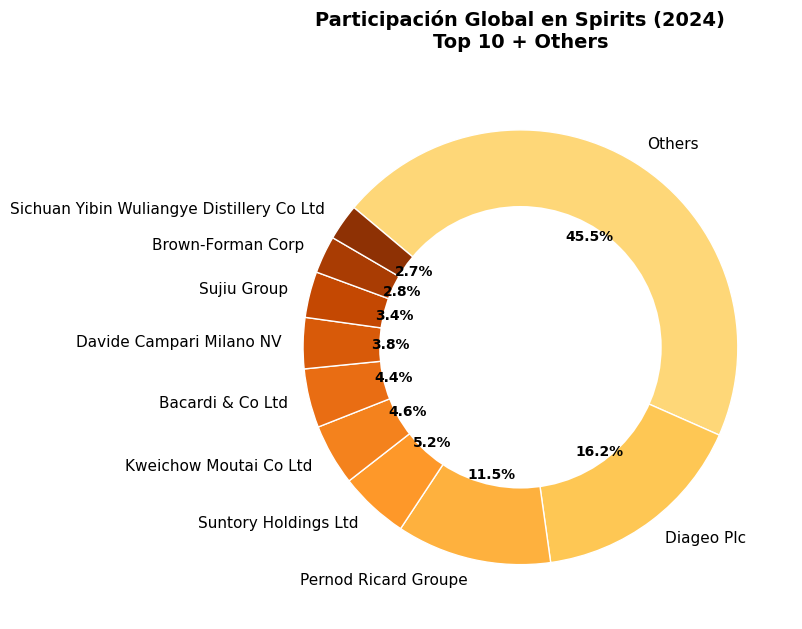

In [8]:
# --- Sacamos el "Total" ---
competidores_global_fil = competidores_global[
    ~competidores_global["company name"].str.casefold().eq("total")
].copy()

# --- Unificamos "Others" de la base antes del ranking ---
competidores_global_fil.loc[
    competidores_global_fil["company name"].str.casefold() == "others", "company name"
] = "Others"

# --- Tomamos el Top 10 ---
top10 = competidores_global_fil.sort_values(by=y2024, ascending=False).head(10).copy()

# --- Preparamos paleta café y amarillos ---
colors = cm.get_cmap("YlOrBr")(np.linspace(0.3, 0.9, len(top10)))

# --- Hacemos un gráfico tipo doughnut  ---
fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(
    top10[y2024],
    labels=top10["company name"],
    autopct="%1.1f%%",
    startangle=140,
    counterclock=False,
    colors=colors,
    wedgeprops={"linewidth": 1, "edgecolor": "white"}  # bordes blancos para agregar elegancia
)

# Añadimos un círculo blanco al centro para simular "doughnut"
centre_circle = plt.Circle((0, 0), 0.65, fc="white")
fig.gca().add_artist(centre_circle)

# --- Personalizamos el texto ---
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=11)

# --- Colocamos un mejor título ---
ax.set_title("Participación Global en Spirits (2024)\nTop 10 + Others", 
             fontsize=14, weight="bold", pad=20)

plt.tight_layout()
plt.show()

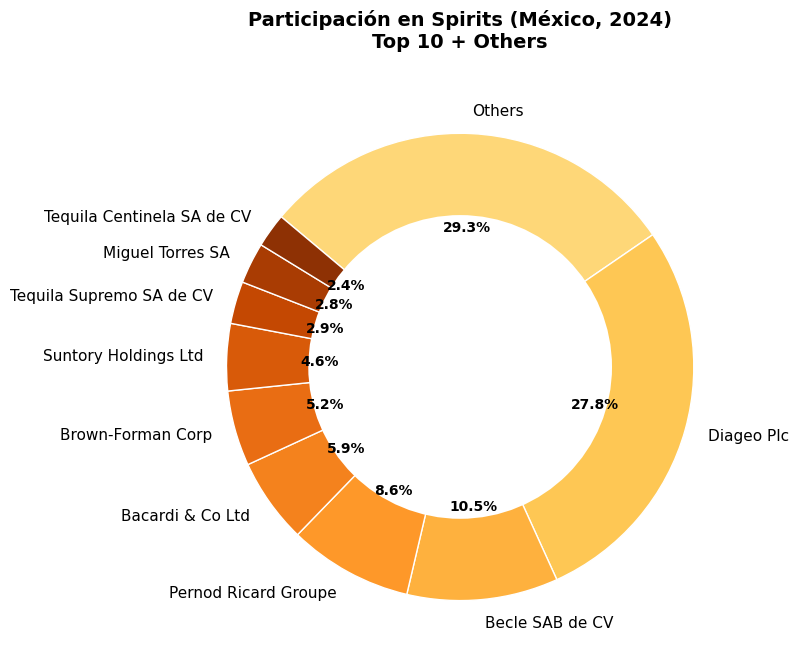

In [11]:

# ------------------------------------ Ahora hacemos el caso para México ---------------------------------------
# --- Filtramso competidores en México ---
pais = "Mexico"
competidores_mex = (
    brand_sel[brand_sel[geo_col] == pais]
    .groupby("company name", as_index=False)[y2024]
    .sum()
    .sort_values(by=y2024, ascending=False)
    .reset_index(drop=True)
)

# Análogamente:
# --- Excluimos "Total" y unificar "Others" ---
competidores_mex = competidores_mex[~competidores_mex["company name"].str.casefold().eq("total")]
competidores_mex.loc[
    competidores_mex["company name"].str.casefold() == "others", "company name"
] = "Others"
competidores_mex = competidores_mex.groupby("company name", as_index=False)[y2024].sum()

# --- Tomamos el Top 10 ---
top10_mex = competidores_mex.sort_values(by=y2024, ascending=False).head(10).copy()

# --- Preparamos paleta café y amarillos ---
colors = cm.get_cmap("YlOrBr")(np.linspace(0.3, 0.9, len(top10_mex)))

# --- Hacemos gráfico tipo doughnut ---
fig, ax = plt.subplots(figsize=(8, 8))

wedges, texts, autotexts = ax.pie(
    top10_mex[y2024],
    labels=top10_mex["company name"],
    autopct="%1.1f%%",
    startangle=140,
    counterclock=False,
    colors=colors,
    wedgeprops={"linewidth": 1, "edgecolor": "white"}  # bordes blancos
)

# Añadimos un círculo blanco al centro para simular "doughnut"
centre_circle = plt.Circle((0, 0), 0.65, fc="white")
fig.gca().add_artist(centre_circle)

# --- Personalizamos el texto ---
plt.setp(autotexts, size=10, weight="bold", color="black")
plt.setp(texts, size=11)

# --- Agregamos el título ---
ax.set_title("Participación en Spirits (México, 2024)\nTop 10 + Others", 
             fontsize=14, weight="bold", pad=20)

plt.tight_layout()
plt.show()

In [48]:
#  Para ver el tamaño del mercado:
#  Cargamos el archivo

df = pd.read_excel("Becle_por_pais.xlsx")

# La columna 2024 está como número, la renombramos
df = df.rename(columns={2024: "US$mm_2024"})

# Seleccionamos las columnas relevantes
tabla_resumen = df[["Geography", "US$mm_2024", "CAGR ('19-'24)", "% CAGR ('19-'24)"]]
tabla_resumen = tabla_resumen[tabla_resumen["Geography"] != "World"]
tabla_resumen

# Ordenamos y seleccionamos el top 5
top5 = tabla_resumen.sort_values(by="US$mm_2024", ascending=False).head(5).reset_index(drop=True)
top5

,Geography,US$mm_2024,CAGR ('19-'24),% CAGR ('19-'24)
0,USA,4021.7,0.128024,12.802434
1,Mexico,758.7,0.052190,5.219019
2,Japan,281.6,0.084395,8.439477
3,Canada,197.6,0.053458,5.345844
4,United Kingdom,146.5,0.081535,8.153477


In [49]:
# Imprimimos en formato tabla
print(tabulate(top5, headers="keys", tablefmt="fancy_grid", showindex=False, floatfmt=".2f"))

╒════════════════╤══════════════╤══════════════════╤════════════════════╕
│ Geography      │   US$mm_2024 │   CAGR ('19-'24) │   % CAGR ('19-'24) │
╞════════════════╪══════════════╪══════════════════╪════════════════════╡
│ USA            │      4021.70 │             0.13 │              12.80 │
├────────────────┼──────────────┼──────────────────┼────────────────────┤
│ Mexico         │       758.70 │             0.05 │               5.22 │
├────────────────┼──────────────┼──────────────────┼────────────────────┤
│ Japan          │       281.60 │             0.08 │               8.44 │
├────────────────┼──────────────┼──────────────────┼────────────────────┤
│ Canada         │       197.60 │             0.05 │               5.35 │
├────────────────┼──────────────┼──────────────────┼────────────────────┤
│ United Kingdom │       146.50 │             0.08 │               8.15 │
╘════════════════╧══════════════╧══════════════════╧════════════════════╛


# Segunda Slide

#### Company Overview

##### Instrucciones:

1.- Hacer la segunda slide de su presentación final: Company Overview


2.- Hacer análisis vertical y horizontal

In [35]:

# --------- Definimos los parámetros ----------
WORLD_FILE = "Passport Spirits World.xlsx"  
SHEET_NAME = "Country"
TARGET_YEARS = ["2029", "2024"]             # seleccionamos los años en los que centraremos el análisis.
EXCLUDE_AGGREGATE = "world"                 # excluímos la fila "World" del denominador ya que se tendría información doble
TOP_N = 10

In [36]:

def load_world_country(file_path, sheet_name):
    """
    Carga la hoja 'Country' con el header correcto (fila 6 en Excel -> header=5)
    y devuelve el DataFrame sin tocar.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=5)
    return df

def filter_spirits_current_usd(df):
    """
    Filtra: Category=Spirits, Data Type=Total Value RSP, Unit con 'USD', Current Prices.
    Renombra 'Geography' -> 'Country' si existe.
    """
    mask = (
        df["Category"].astype(str).str.strip().str.lower().eq("spirits") &
        df["Data Type"].astype(str).str.strip().str.lower().eq("total value rsp") &
        df["Unit"].astype(str).str.contains("USD", case=False, na=False) &
        df["Current Constant"].astype(str).str.lower().str.contains("current", na=False)
    )
    out = df.loc[mask].copy()
    if "Geography" in out.columns:
        out = out.rename(columns={"Geography": "Country"})
    return out

def year_columns(df):
    """Detecta las columnas que son años (cadenas numéricas tipo '2019')."""
    cols = [c for c in df.columns if str(c).isdigit()]
    return [str(c) for c in cols]

In [50]:
def compute_vertical_share_world(df_use, year):
    """
    Calcula % global por país usando como denominador el valor 'World' del año.
    Esto alinea con dividir entre World (tu método).
    """
    if year not in df_use.columns:
        raise KeyError("El año {} no existe. Años disponibles: {}".format(year, year_columns(df_use)))

    # Normaliza nombres
    df = df_use.copy()
    df["Country"] = df["Country"].astype(str).str.strip()

    # Valor de World (denominador)
    world_val = pd.to_numeric(df.loc[df["Country"].str.lower()=="world", year], errors="coerce").squeeze()
    if pd.isna(world_val) or world_val == 0:
        raise ValueError("No se encontró 'World' para el año {} o es 0.".format(year))

    # Tomamos todos los países (excluimos World para el ranking)
    df = df[df["Country"].str.lower() != "world"].copy()
    df[year] = pd.to_numeric(df[year], errors="coerce")

    # Participación global
    df["share_%"] = 100 * df[year] / world_val
    df = df.dropna(subset=["share_%"]).sort_values("share_%", ascending=False).reset_index(drop=True)
    return df

def show_topn_table_and_chart(df_share, year, top_n=10):
    """Muestra tabla + gráfico (no guarda archivos)."""
    topn = df_share.head(top_n).copy()
    topn["share_%"] = topn["share_%"].round(2)

    # Tabla
    print("\nTop {} - Global Spirits Market Share by Country - {} (denominador = World)\n".format(top_n, year))
    display(topn[["Country", "share_%"]])

    # Others = 100 - suma(topN) - si quieres el Others real, toma 100 - suma(todos)
    others_topn = 100 - topn["share_%"].sum()
    print("Others (respecto a Top{}): ~{:.1f}%".format(top_n, others_topn))

    # Gráfico
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(topn["Country"], topn["share_%"])
    ax.set_title("Global Spirits Market Share by Country - {} (Top {}, denom=World)".format(year, top_n))
    ax.set_ylabel("Share (%)")
    ax.set_xlabel("Country")
    ax.set_xticks(range(len(topn["Country"])))
    ax.set_xticklabels(topn["Country"], rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

Años detectados: ['2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029']

Procesando año: 2024
Others (todos los países): ~2.5%

Top 5 - Global Spirits Market Share by Country - 2024 (denominador = World)



,Country,share_%
0,China,27.36
1,USA,18.39
2,India,6.12
3,United Kingdom,3.78
4,France,3.19


Others (respecto a Top5): ~41.2%


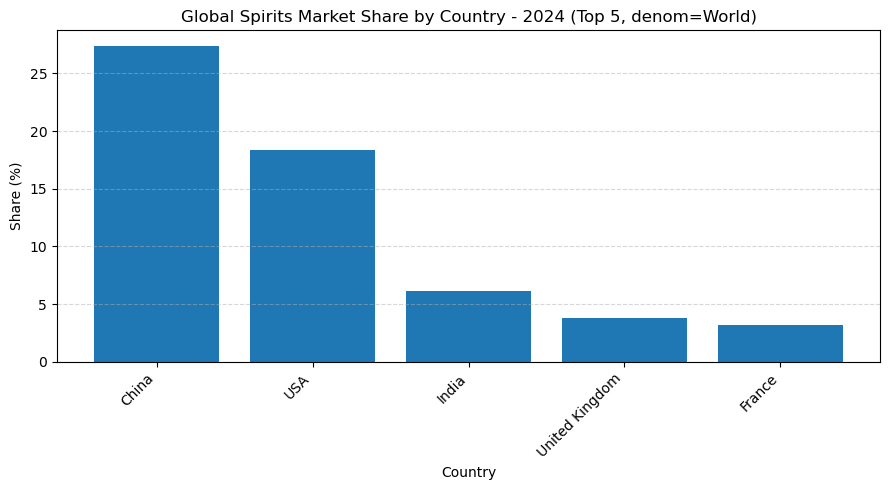


Procesando año: 2029
Others (todos los países): ~2.8%

Top 5 - Global Spirits Market Share by Country - 2029 (denominador = World)



,Country,share_%
0,China,23.48
1,USA,17.54
2,India,10.05
3,United Kingdom,3.49
4,Japan,2.99


Others (respecto a Top5): ~42.5%


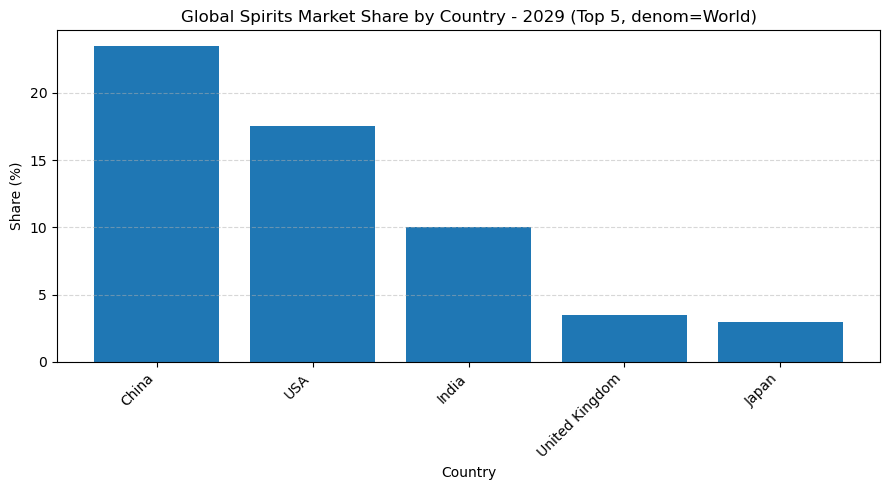

In [45]:
# Cargamos el filtro
df_raw = load_world_country(WORLD_FILE, SHEET_NAME)
df_use = filter_spirits_current_usd(df_raw)
print("Años detectados:", year_columns(df_use))

# Seleccionamos los años
for y in ["2024", "2029"]:
    print("\nProcesando año:", y)
    df_share = compute_vertical_share_world(df_use, y) 
    # Others real (todos los países, no solo top N)
    others_all = 100 - df_share["share_%"].sum()
    print("Others (todos los países): ~{:.1f}%".format(others_all))
    show_topn_table_and_chart(df_share, y, top_n=5)

In [51]:
def stacked_share_chart_anchored(df_use, years, anchor_year="2029", top_n=5):
    """
    100% stacked bar chart con TopN del año anchor_year + Others.
    Colores en gamas de amarillo y etiquetas internas con %.
    """
    # 1) TopN del año ancla
    df_anchor = compute_vertical_share_world(df_use, anchor_year)[["Country", "share_%"]]
    anchor_countries = list(df_anchor.head(top_n)["Country"])

    # 2) Construir tabla por año SOLO con esos países + Others
    rows = {}
    for y in years:
        df_y = compute_vertical_share_world(df_use, y)[["Country", "share_%"]]
        s = df_y.set_index("Country")["share_%"].reindex(anchor_countries).fillna(0.0)
        s.loc["Others"] = max(0.0, 100 - s.sum())
        rows[y] = s

    df_stacked = pd.DataFrame(rows).T

    # 3) Paleta en amarillos (YlOrBr → amarillo → naranja → café claro)
    cmap = plt.cm.get_cmap("YlOrBr", len(df_stacked.columns))
    colors = [cmap(i) for i in range(len(df_stacked.columns))]

    # 4) Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = pd.Series([0]*len(df_stacked), index=df_stacked.index)

    for i, col in enumerate(df_stacked.columns):
        bars = ax.bar(df_stacked.index, df_stacked[col], bottom=bottom,
                      label=col, color=colors[i])
        # Etiquetas internas
        for bar in bars:
            height = bar.get_height()
            if height > 2:  # solo mostrar si >2%
                ax.text(
                    bar.get_x() + bar.get_width()/2,
                    bar.get_y() + height/2,
                    f"{height:.1f}%",
                    ha="center", va="center", color="black", fontsize=9, fontweight="bold"
                )
        bottom += df_stacked[col]

    # Estética
    ax.set_title(f"Global Spirits Market Share",
                 fontsize=14, fontweight="bold")
    ax.set_ylabel("Share (%)", fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylim(0, 100)
    ax.tick_params(axis="x", labelsize=11)
    ax.tick_params(axis="y", labelsize=11)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    ax.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=10)
    plt.tight_layout()
    plt.show()

    return df_stacked

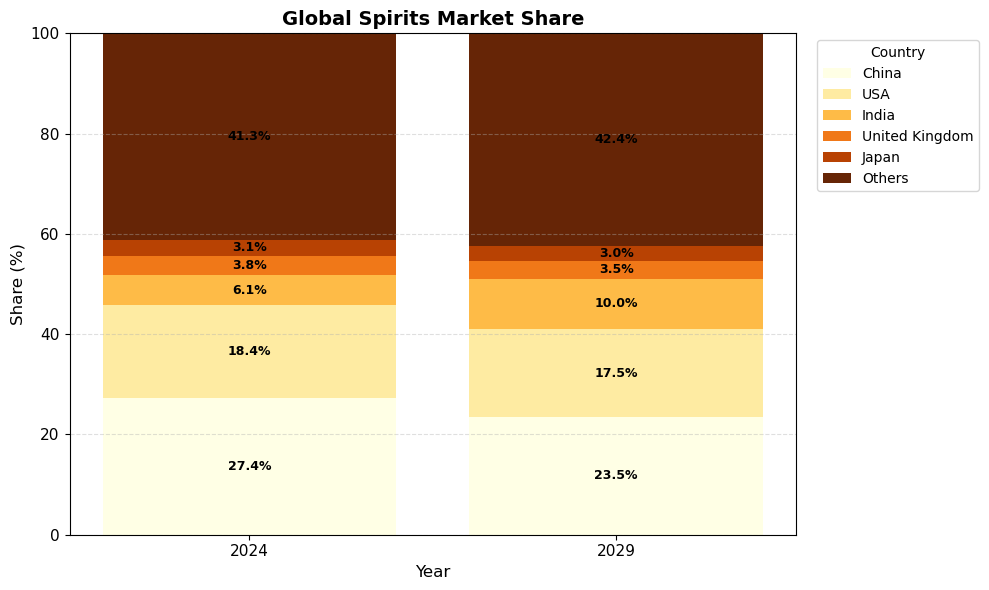

Country,China,USA,India,United Kingdom,Japan,Others
2024,27.36,18.39,6.12,3.78,3.10,41.25
2029,23.48,17.54,10.05,3.49,2.99,42.44


In [47]:
years = ["2024", "2029"]
stacked_df = stacked_share_chart_anchored(df_use, years, anchor_year="2029", top_n=5)
display(stacked_df.round(2))

## Horizontal

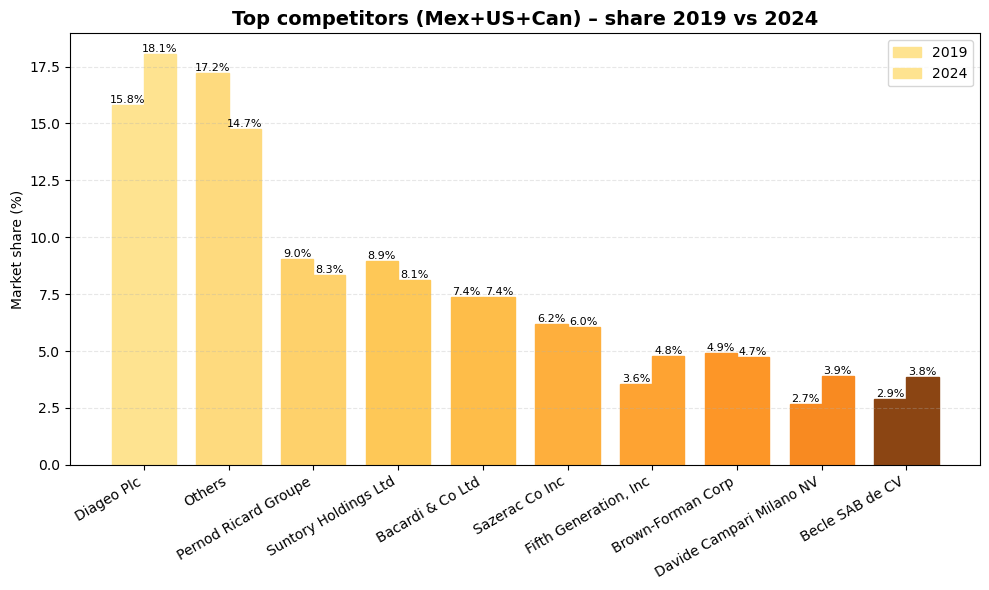

In [38]:
# -------------- Preparamos los parámetros -----------------------------

FILE = "Passport Spirits Mex-US-Can.xlsx"
SHEET = "USD"
HEADER_ROW = 5
REGION = "Canada,Mexico,USA"
CAT = "Spirits"
DTYPE = "Total Value RSP"
ANIO_INI, ANIO_FIN = 2019, 2024
TOP_N = 10
PALETA = "YlOrBr"
BECLE_NAME = "Becle SAB de CV"  

# Definimos el dataframe sobre el que se trabajará.
df = pd.read_excel(FILE, sheet_name=SHEET, header=HEADER_ROW)
for c in ["Geographies","Category","Company Name","Data Type","Unit"]:
    df[c] = df[c].astype(str).str.strip()

mask = (
    (df["Geographies"] == REGION) &
    (df["Category"] == CAT) &
    (df["Data Type"] == DTYPE) &
    (df["Unit"].str.contains("USD", case=False, na=False))
)
df_use = df.loc[mask, ["Company Name", str(ANIO_INI), str(ANIO_FIN)]].copy()
for y in [str(ANIO_INI), str(ANIO_FIN)]:
    df_use[y] = pd.to_numeric(df_use[y], errors="coerce")

df_use = (
    df_use.dropna()
          .groupby("Company Name", as_index=False)[[str(ANIO_INI), str(ANIO_FIN)]].sum()
)
df_use = df_use[~df_use["Company Name"].str.contains("Total", case=False, na=False)]
# Shares (%)
tot_0, tot_1 = df_use[str(ANIO_INI)].sum(), df_use[str(ANIO_FIN)].sum()
df_use["%Mkt_2019"] = 100 * df_use[str(ANIO_INI)] / tot_0 if tot_0 else 0
df_use["%Mkt_2024"] = 100 * df_use[str(ANIO_FIN)] / tot_1 if tot_1 else 0

# Hacemos una tbla ordenada por 2024
tabla = df_use.sort_values("%Mkt_2024", ascending=False).reset_index(drop=True)

# Helpers de color
def pick_colors(n, cmap_name=PALETA, low=0.25, high=0.95):
    cm = plt.cm.get_cmap(cmap_name)
    return [cm(x) for x in np.linspace(low, high, n)]

HILIGHT = "#8b4513"  # café para resaltar Becle
NEUTRO  = pick_colors(20)  # paleta base


# ------------------------- Colocamos el TOP competidores (Top-N) -------------------------------
top = tabla.head(TOP_N).copy()
# Si Becle no está en el Top-N, lo añadimos y reordenamos
if BECLE_NAME not in top["Company Name"].values and BECLE_NAME in tabla["Company Name"].values:
    top = pd.concat([top, tabla[tabla["Company Name"]==BECLE_NAME]]).drop_duplicates("Company Name")
top = top.sort_values("%Mkt_2024", ascending=False).reset_index(drop=True)

x = np.arange(len(top))
w = 0.38

fig, ax = plt.subplots(figsize=(10,6))
bars_2019 = ax.bar(x - w/2, top["%Mkt_2019"], width=w, label=str(ANIO_INI))
bars_2024 = ax.bar(x + w/2, top["%Mkt_2024"], width=w, label=str(ANIO_FIN))

# Coloreamos Becle
for bars in (bars_2019, bars_2024):
    for i, b in enumerate(bars):
        name = top.iloc[i]["Company Name"]
        b.set_color(HILIGHT if name == BECLE_NAME else NEUTRO[i % len(NEUTRO)])

ax.set_title(f"Top competitors (Mex+US+Can) – share {ANIO_INI} vs {ANIO_FIN}", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(top["Company Name"], rotation=30, ha="right")
ax.set_ylabel("Market share (%)")
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend()
# Colocamos los valores
for bars in (bars_2019, bars_2024):
    for b in bars:
        h = b.get_height()
        if h >= 1.5:
            ax.text(b.get_x()+b.get_width()/2, h, f"{h:.1f}%", ha="center", va="bottom", fontsize=8)
plt.tight_layout()
plt.show()


C:\Users\luz_s\AppData\Local\Temp\ipykernel_22300\3481858404.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wf["Company Name"], rotation=30, ha="right")


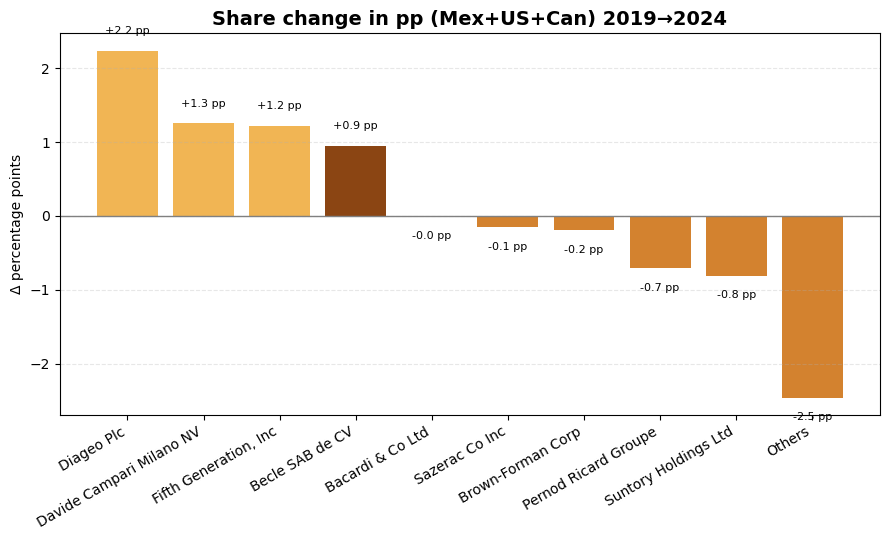

In [32]:

# ------------ Colocamos un gráfico de cascada (Waterfall) de cambio en puntos porcentuales (pp) -------------------
tabla["Δ pp (19→24)"] = tabla["%Mkt_2024"] - tabla["%Mkt_2019"]
wf = tabla.head(TOP_N).copy()
# Garantizamos presencia de Becle
if BECLE_NAME not in wf["Company Name"].values and BECLE_NAME in tabla["Company Name"].values:
    wf = pd.concat([wf, tabla[tabla["Company Name"]==BECLE_NAME]]).drop_duplicates("Company Name")

wf = wf.sort_values("Δ pp (19→24)", ascending=False).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(9,5.5))
bars = ax.bar(wf["Company Name"], wf["Δ pp (19→24)"],
              color=[HILIGHT if n==BECLE_NAME else "#f1b554" if v>=0 else "#d3822f"
                     for n, v in zip(wf["Company Name"], wf["Δ pp (19→24)"])]
             )
ax.axhline(0, color="gray", linewidth=1)
ax.set_title(f"Share change in pp (Mex+US+Can) {ANIO_INI}→{ANIO_FIN}", fontsize=14, fontweight="bold")
ax.set_ylabel("Δ percentage points")
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.set_xticklabels(wf["Company Name"], rotation=30, ha="right")
for b in bars:
    h = b.get_height()
    ax.text(b.get_x()+b.get_width()/2, h + (0.2 if h>=0 else -0.2), f"{h:+.1f} pp",
            ha="center", va="bottom" if h>=0 else "top", fontsize=8)
plt.tight_layout()
plt.show()

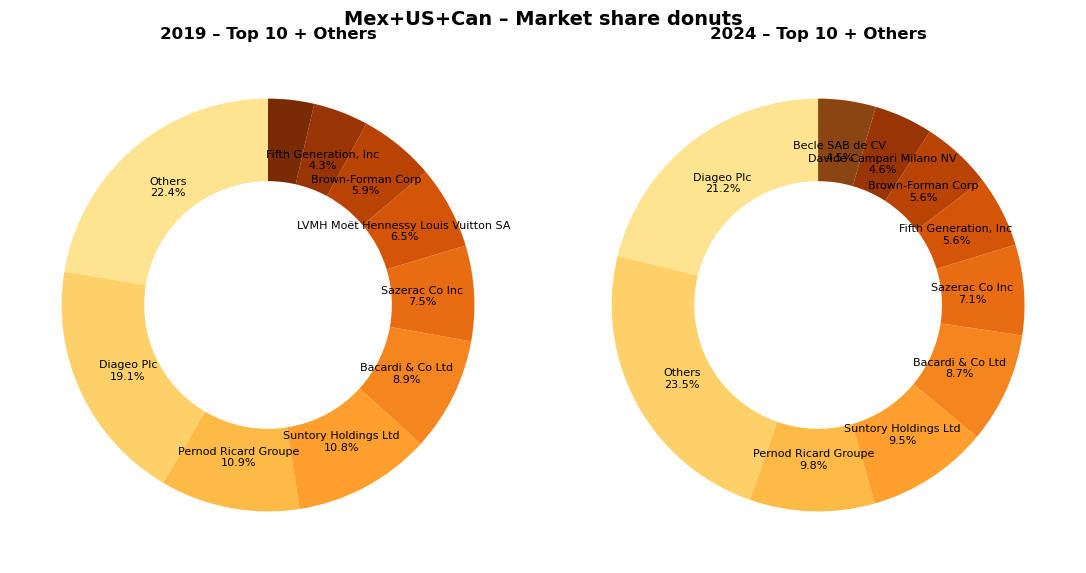

In [39]:

# ------------ Hacemo un gráfico de Donut comparativo (2019 vs 2024)
#    Top-N + Others (para que sumen 100%)

def topN_plus_others(df_shares, col_pct, topn=TOP_N):
    s = df_shares.sort_values(col_pct, ascending=False)[["Company Name", col_pct]].copy()
    top = s.head(topn).set_index("Company Name")[col_pct]
    others = max(0.0, 100 - top.sum())
    top.loc["Others"] = others
    return top

pie_2019 = topN_plus_others(tabla, "%Mkt_2019", TOP_N)
pie_2024 = topN_plus_others(tabla, "%Mkt_2024", TOP_N)

def donut(ax, series, title):
    labels = series.index.tolist()
    values = series.values
    # colores: resaltar Becle
    cols = pick_colors(len(labels))
    cols = [HILIGHT if lab==BECLE_NAME else cols[i] for i, lab in enumerate(labels)]
    wedges, texts = ax.pie(values, startangle=90, colors=cols, wedgeprops=dict(width=0.4))
    ax.set_title(title, fontsize=12, fontweight="bold")
    # autolabel > 4%
    total = values.sum()
    for w, v, lab in zip(wedges, values, labels):
        p = 100*v/total
        if p >= 4:
            ang = (w.theta2+w.theta1)/2
            x = 0.75*np.cos(np.deg2rad(ang))
            y = 0.75*np.sin(np.deg2rad(ang))
            ax.text(x, y, f"{lab}\n{p:.1f}%", ha="center", va="center", fontsize=8)

fig, axes = plt.subplots(1, 2, figsize=(11,5.8), subplot_kw=dict(aspect='equal'))
donut(axes[0], pie_2019, f"{ANIO_INI} – Top {TOP_N} + Others")
donut(axes[1], pie_2024, f"{ANIO_FIN} – Top {TOP_N} + Others")
plt.suptitle("Mex+US+Can – Market share donuts", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

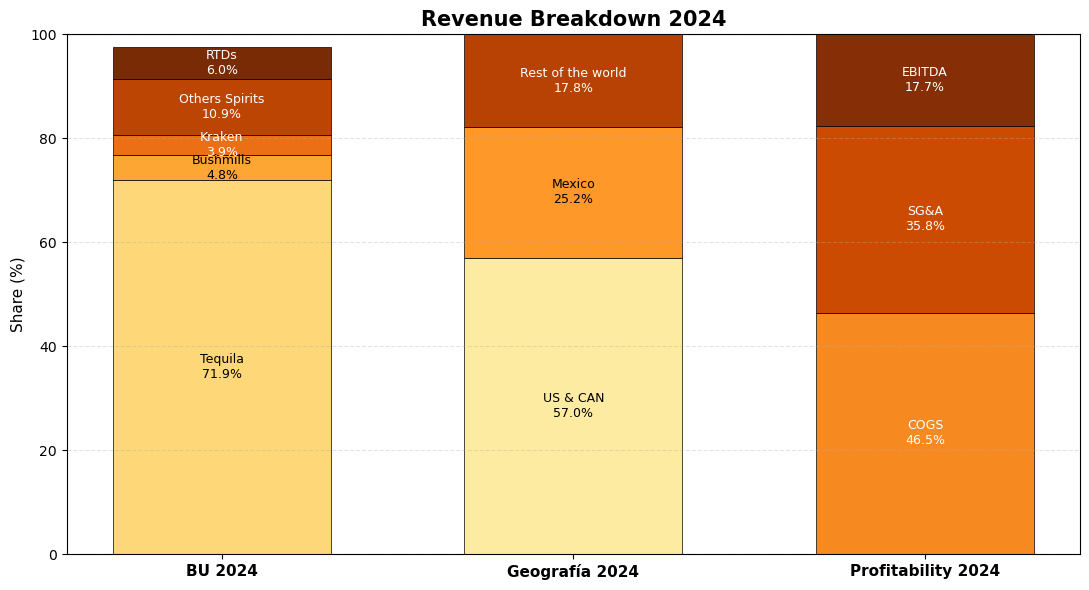

In [40]:
# Hacemos el revenue Breakdown 2024
# Datos que ya calculamos antes

BU_2024 = {"Tequila": 71.9, "Bushmills": 4.8, "Kraken": 3.9, "Others Spirits": 10.9, "RTDs":6.0}
GEO_2024 = {"US & CAN": 57.0, "Mexico": 25.2, "Rest of the world": 17.8}
PROF_2024_ord = {
    "COGS": 46.5,     # % real calculado
    "SG&A": 35.8,     # % real calculado
    "EBITDA": 17.7    # residual para cerrar 100%
}

groups      = ["BU 2024", "Geography 2024", "Profitability 2024"]
stack_dicts = [BU_2024, GEO_2024, PROF_2024_ord]


# Aseguramos los mismos colores: paleta amarillos y cafés

cmap = plt.cm.get_cmap("YlOrBr", 9)
def pick_colors(values):
    vals = np.array(list(values), dtype=float)
    ranks = vals.max() - vals
    ranks = (ranks - ranks.min()) / (ranks.ptp() + 1e-9)
    idx = (3 + ranks * 5).round().astype(int)
    return [cmap(i) for i in idx]


# Hacemos el gráfico
# helpers de color 
def build_color_map(keys, cmap_name="YlOrBr", low=0.20, high=0.92):
    """Asigna colores espaciados y consistentes a cada etiqueta."""
    cm = plt.cm.get_cmap(cmap_name)
    stops = np.linspace(low, high, len(keys))
    return {k: cm(s) for k, s in zip(keys, stops)}

def txt_color_on(rgba):
    r, g, b, _ = rgba
    # luminancia relativa; si es oscuro, texto blanco
    y = 0.2126*r + 0.7152*g + 0.0722*b
    return "black" if y > 0.6 else "white"

# Colocamos las paletas fijas por barra (todas en gama amarillos) 
COLOR_BU   = build_color_map(list(BU_2024.keys()),  "YlOrBr", 0.30, 0.95)
COLOR_GEO  = build_color_map(list(GEO_2024.keys()), "YlOrBr", 0.20, 0.80)
# Profitability en orden lógico: COGS -> SG&A -> EBITDA
COLOR_PROF = { "COGS": plt.cm.YlOrBr(0.55),
               "SG&A": plt.cm.YlOrBr(0.75),
               "EBITDA": plt.cm.YlOrBr(0.92) }

groups = [
    ("BU 2024", BU_2024, COLOR_BU),
    ("Geografía 2024", GEO_2024, COLOR_GEO),
    ("Profitability 2024", PROF_2024_ord, COLOR_PROF),
]

# Graficamos
fig, ax = plt.subplots(figsize=(11, 6))
x = np.arange(len(groups))
bar_w = 0.62

for i, (title, data, cdict) in enumerate(groups):
    bottom = 0.0
    for label, val in data.items():
        col = cdict[label]
        ax.bar(x[i], val, bottom=bottom, width=bar_w, color=col,
               edgecolor="black", linewidth=0.5)
        ax.text(x[i], bottom + val/2, f"{label}\n{val:.1f}%",
                ha="center", va="center", fontsize=9, color=txt_color_on(col))
        bottom += val

ax.set_xticks(x)
ax.set_xticklabels([g[0] for g in groups], fontsize=11, fontweight="bold")
ax.set_ylim(0, 100)
ax.set_ylabel("Share (%)", fontsize=11)
ax.set_title("Revenue Breakdown 2024", fontsize=15, fontweight="bold")
ax.grid(axis="y", linestyle="--", alpha=0.35)
ax.axhline(100, color="gray", linewidth=0.8)

plt.tight_layout()
plt.show()